# Title of new blog post goes here

In a [previous post](https://medium.com/ibm-data-ai/how-to-load-pytorch-models-340-times-faster-with-ray-8be751a6944c), we introduced the concept of *zero-copy model loading*. Zero-copy model loading involves keeping the weights of a machine learning model in shared memory, so that different processes can load the model for inference instantly without copying data.

We showed that the Plasma object store integrated into [Ray](https://www.ray.io/) makes it easy to do zero-copy model loading, and that implementing this technique on Ray can accelerate model loading by several orders of magnitude. If you'd like to find out more about the details of zero-copy model loading, follow [this link](https://medium.com/ibm-data-ai/how-to-load-pytorch-models-340-times-faster-with-ray-8be751a6944c) to view the previous post.

In this post, we focus on how zero-copy model loading lets you deploy models in production with fewer resources, fewer knobs to tune, and better performance. We introduce `zerocopy`, a Python package that makes it extra simple to apply the technique. We show how to deploy models using with `zerocopy` and Ray Serve. Finally, we present an end-to-end model serving benchmark that shows how we can serve multiple large NLP models with a single cloud VM and achieve (**TODO: final numbers**)x better scalability with no tuning.

In [16]:
# Initialization and import code goes in this cell.

# Imports: Python core, then third-party, then local.
# Try to keep each block in alphabetical order, or the linter may get angry.

import asyncio
import concurrent.futures
import requests
import starlette
import time
import os
import json

import matplotlib.pyplot as plt
import pandas as pd

import ray
from ray import serve
import torch
import transformers

import zerocopy

# Fix silly warning messages about parallel tokenizers
os.environ['TOKENIZERS_PARALLELISM'] = 'False'


# Reduce the volume of warning messages from `transformers`
transformers.logging.set_verbosity_error()


def reboot_ray():
    if ray.is_initialized():
        ray.shutdown()

    if torch.cuda.is_available():
        return ray.init(num_gpus=1)
    else:
        return ray.init()

In [17]:
# Don't include this cell in the blog post.
# Fire up Ray
serve.shutdown()
reboot_ray()
serve.start()

# Wait a moment to make sure that all log output goes to this cell
time.sleep(1.)

2022-03-07 11:28:47,963	INFO services.py:1374 -- View the Ray dashboard at http://127.0.0.1:8265
(ServeController pid=4570) 2022-03-07 11:28:52,095	INFO checkpoint_path.py:16 -- Using RayInternalKVStore for controller checkpoint and recovery.
(ServeController pid=4570) 2022-03-07 11:28:52,203	INFO http_state.py:98 -- Starting HTTP proxy with name 'SERVE_CONTROLLER_ACTOR:nhrXXr:SERVE_PROXY_ACTOR-node:127.0.0.1-0' on node 'node:127.0.0.1-0' listening on '127.0.0.1:8000'
2022-03-07 11:28:52,625	INFO api.py:475 -- Started Serve instance in namespace '0487c778-3b08-4b11-9092-6eca28563756'.
(HTTPProxyActor pid=4572) INFO:     Started server process [4572]


## Introducing `zerocopy`

Our previous post included code snippets that show how to rewrite a PyTorch model to use zero-copy model loading. 
We've recently released a Python package, `zerocopy`, that lets you apply this technique to your models without having to copy and paste Python code. 
This package is part of IBM's [Project Codeflare](https://github.com/project-codeflare), a framework to simplify the integration, scaling and acceleration of complex multi-step analytics and machine learning pipelines.

**(TODO: Publish the package to PyPI and insert installation instructions here)**

Using the `zerocopy` package is a three-step process:
1. Import the package.
2. Move your model's weights onto the Plasma object store.
3. Run your model in an asynchronous Ray task.

Let's show these three steps in action with the [BERT language model](https://arxiv.org/abs/1810.04805) as implemented in the [Transformers](https://huggingface.co/docs/transformers/index) library.

Step 1 is just a Python `import` statement:
```python 
import zerocopy
```

Then it's on to step 2: Moving your model's weights onto Plasma. You will of course need a PyTorch model to do this step. Here we use the Transformers library's `from_pretrained()` function to load a copy of BERT.

In [18]:
bert_model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [19]:
# Don't include this cell in the blog
# Load a tokenizer to go with the model
bert_tokenizer = transformers.BertTokenizer.from_pretrained(
    'bert-base-uncased')
text = "What's another word for 'thesaurus'?"
bert_input = bert_tokenizer(text, return_tensors='pt')
bert_input

{'input_ids': tensor([[  101,  2054,  1005,  1055,  2178,  2773,  2005,  1005,  1996, 22244,
          1005,  1029,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

To move this model's weights onto Plasma, you first need to pass the model through `zerocopy.extract_tensors()`, which separates the weights from the model's Python code. This function returns a copy of the model without any weights and a separate Python dictionary containing the weights. Then you need to copy the model and its weights to Plasma using the function `ray.put()`. You can do both of these operations with a single line of Python code. 

In [20]:
bert_ref = ray.put(zerocopy.extract_tensors(bert_model))

The return value from `ray.put()` is a Ray [object reference](https://arrow.apache.org/docs/python/plasma.html#object-ids). This object reference lets you load the model almost instantly from any location on your Ray cluster. This capability is what enables step 3: Running your model in an asynchronous Ray task.

In our previous post, we showed how you can define a stateless Ray task that loads the model, runs inference over an input, and returns the result. The `zerocopy` package includes a built-in function `call_model()` that lets you do all these steps in one line of Python code. You just pass in the object reference, the name of the method on the model you want to invoke, and the arguments to that method. `call_model.remote()` takes care of the rest. 

In [21]:
result_ref = zerocopy.call_model.remote(bert_ref, [], bert_input, '__call__')

As with any other Ray task, `call_model.remote()` returns a [future](https://docs.ray.io/en/latest/ray-overview/index.html#parallelizing-python-java-functions-with-ray-tasks) --- a Ray object reference to the place where the result will appear once the task has completed. You can retrieve this result with `ray.get()`.

In [22]:
result = ray.get(result_ref)

The time to invoke the rewritten model is almost the same as running the model locally.

In [23]:
print("       Time to run locally: ", end="")
%timeit bert_model(**bert_input)
print("Time to run with zero-copy: ", end="")
%timeit ray.get(zerocopy.call_model.remote(bert_ref, [], bert_input))

       Time to run locally: 77.5 ms ± 951 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Time to run with zero-copy: 87.1 ms ± 2.76 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


If you run inference multiple times, `zero_copy.call_model()` can send those inference requests to separate Ray tasks that run in parallel.

In [25]:
# TODO: Use output from running this cell on a large machine for the blog post
def run_local(num_repeats: int):
    return [bert_model(**bert_input)
            for _ in range(num_repeats)]


def run_zero_copy(num_repeats: int):
    return ray.get([zerocopy.call_model.remote(bert_ref, [], bert_input)
                    for _ in range(num_repeats)])


NUM_REPEATS = 200
print(f"Time to run {NUM_REPEATS} times with zero-copy: ", end="")
%timeit -r 3 run_zero_copy(NUM_REPEATS)
print(f"       Time to run {NUM_REPEATS} times locally: ", end="")
%timeit -r 3 run_local(NUM_REPEATS)

Time to run 200 times with zero-copy: 4.02 s ± 134 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
       Time to run 200 times locally: 15.9 s ± 38.5 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


## Model inference pipelines

With the `zerocopy` library's `extract_tensors()` and `call_model()` functions, you can apply zero-copy model loading to a Pytorch model with two lines of Python. But what about the end-to-end program that this model came from? 

Most machine learning models require additional code to apply them in a meaningful way. NLP models in particular require *preprocessing* to convert natural language text into a format the model can understand and *postprocessing* to convert the model's answer into a format that a person can understand. 

It's common to package the model as *pipeline* that includes preprocessing, inference, and postprocessing bundled together in a single Python object. For example, the Transformers library's BERT model that we have been using in our examples so far comes with a pipeline that performs the end-to-end task of *masked language modeling*: Identifying the most likely word to fill in a blank.

In [26]:
bert_pipeline = transformers.pipeline('fill-mask', model='bert-base-uncased')
bert_pipeline('All your base are belong to [MASK].')

[{'score': 0.6013057231903076,
  'token': 2033,
  'token_str': 'me',
  'sequence': 'all your base are belong to me.'},
 {'score': 0.08610764890909195,
  'token': 2032,
  'token_str': 'him',
  'sequence': 'all your base are belong to him.'},
 {'score': 0.054536789655685425,
  'token': 2017,
  'token_str': 'you',
  'sequence': 'all your base are belong to you.'},
 {'score': 0.04619930312037468,
  'token': 2149,
  'token_str': 'us',
  'sequence': 'all your base are belong to us.'},
 {'score': 0.03938837721943855,
  'token': 2068,
  'token_str': 'them',
  'sequence': 'all your base are belong to them.'}]

The `zerocopy` library includes a function `rewrite_pipeline` that transforms any models embedded into Python object into Ray tasks that use zero-copy model loading to load weights. If we apply this function to a pipeline, the resulting rewritten pipeline faithfully performs all the preprocessing and postprocessing that the original pipeline performed. However, this rewritten pipeline runs the embedded PyTorch model in remote Ray tasks.

In [27]:
from pympler import asizeof

zero_copy_bert_pipeline = zerocopy.rewrite_pipeline(bert_pipeline)
print(f"Heap memory used before rewrite: {asizeof.asizeof(bert_pipeline)}")
print(f" Heap memory used after rewrite: {asizeof.asizeof(zero_copy_bert_pipeline)}")

print(f"Output before rewrite: {bert_pipeline('All your base are belong to [MASK].')[0]['score']}")
print(f" Output after rewrite: {zero_copy_bert_pipeline('All your base are belong to [MASK].')[0]['score']}")

Heap memory used before rewrite: 715664
 Heap memory used after rewrite: 6848
Output before rewrite: 0.6013057231903076
 Output after rewrite: 0.6013057231903076


## A better way to deploy models

In a world without zero-copy model loading, anyone who runs deep learning models in production runs into a set of difficult design constraints. If you want to run inference on a model, you need to have the model's weights loaded into a process's memory. But loading the model from storage is orders of magnitude more expensive than running inference. So you need to keep the model perpetually loaded in memory. That means that you need to keep a process around all the time, with the model loaded. This process in turn needs to have enough CPU and memory resources reserved for it so that it can run inference when it is called upon to do so.

These constraints are why systems like [TorchServe](https://github.com/pytorch/serve/blob/master/docs/management_api.md), [TensorFlow Serving](https://www.tensorflow.org/tfx/serving/serving_kubernetes), and [Seldon Core](https://docs.seldon.io/projects/seldon-core/en/latest/workflow/overview.html#e2e-serving-with-model-servers) run each model in its own container, or equivalently in a UNIX process with reserved CPU and memory resources.

**TODO: Find and insert an appropriate block diagram here**

It is possible to achieve good response times and low costs with this design, but you will need to tune many parameters to arrive at that point. How much CPU and memory capacity should you reserve for each model's containers? How many replicas of each container should you keep up at all times? How quickly should you spin up additional replicas in response to changing loads? How quickly should you spin down replicas when they aren't being used? How do you even measure the current load? All of these important decisions take time and energy.

Zero-copy model loading with Ray turns model inference into a stateless process. As long as the weights are in the local segment of the Plasma object store, your code can load a copy of the model instantly, run a single inference request, and then unload the model. This statelessness removes the design constraints that underlie conventional model serving systems. With zero-copy loading, there's no need to manage a pool of containers. Just load all the model weights onto Plasma and let Ray take care of replicating objects to nodes of the cluster as needed.

A small Ray cluster can keep the weights for hundreds of models in shared memory. It can instantly dedicate the entire cluster's CPU resources to a single model. Then it can just as quickly retask all of those resources to a different model. You get an instant, optimal response to whatever workload the application sends your way. And no manual tuning is required.

The best part about this approach is that deploying models with Ray and zero-copy is actually *easier* than deploying them with a traditional model serving framework.

*TODO: Intro to Ray Serve*

Here's how the code to deploy our example BERT model to Ray Serve with zero-copy model loading looks.

First you define an endpoint by creating a small Python class. Then you call wrap an instance of that class in a Ray Serve *deployment*. The code looks like this.

In [21]:
from ray import serve


# Step 1: Define a Ray Serve deployment
@serve.deployment
class MyDeployment:
    def __init__(self):
        transformers.logging.set_verbosity_error()

        # Load the entire pipeline
        self._pipeline = transformers.pipeline('fill-mask', model='bert-base-uncased')

        # Move the model weights to Plasma
        self._pipeline.model = zerocopy.extract_tensors(self._pipeline.model)

    async def __call__(self, request: starlette.requests.Request):
        '''
        Web service entry point.

        Args:
            request: HTTP request object for a REST web service call
                     in the form:
                     { "input": "<input text with [MASK]>" }
        '''
        # Parse JSON. A real deployment would also sanitize the input.
        json_request = await request.json()
        input_ = json_request['input']

        # Preprocessing
        features = self._pipeline.preprocess(input_)

        # Model inference runs asynchronously in a Ray task
        raw_output = await zerocopy.call_model.remote(
            self._pipeline.model, [], features)

        # Postprocessing
        raw_output["input_ids"] = features["input_ids"]
        return self._pipeline.postprocess(raw_output)
    

# Step 2: Attach the deployment to an HTTP endpoint
MyDeployment.options(name='my_model', ray_actor_options={"num_cpus": 0.1}).deploy()

# There is no step 3.

Let's walk through the listing 


Ray Serve automatically handles incoming requests.

In [23]:
print(requests.put('http://127.0.0.1:8000/my_model',
      '{ "input": "All your base are belong to [MASK]." }').text)

[
  {
    "score": 0.6013057231903076,
    "token": 2033,
    "token_str": "me",
    "sequence": "all your base are belong to me."
  },
  {
    "score": 0.08610764890909195,
    "token": 2032,
    "token_str": "him",
    "sequence": "all your base are belong to him."
  },
  {
    "score": 0.054536789655685425,
    "token": 2017,
    "token_str": "you",
    "sequence": "all your base are belong to you."
  },
  {
    "score": 0.04619930312037468,
    "token": 2149,
    "token_str": "us",
    "sequence": "all your base are belong to us."
  },
  {
    "score": 0.03938837721943855,
    "token": 2068,
    "token_str": "them",
    "sequence": "all your base are belong to them."
  }
]


In [28]:
# Don't include this cell in the blog.
# Alternate version uses a multithreaded actor to run the pipeline via
# its __call__ method.

@ray.remote
class PipelineActor:
    '''
    Threaded Ray actor
    '''
    def __init__(self):
        transformers.logging.set_verbosity_error()
        pipeline_tmp = transformers.pipeline('fill-mask', model='bert-base-uncased')
        self._pipeline = zerocopy.rewrite_pipeline(pipeline_tmp)

    def run(self, input_: str):
        # Model inference calls inside this pipeline will happen in remote
        # Ray tasks.
        return self._pipeline(input_)


@serve.deployment
class MyDeployment2:
    def __init__(self):
        self._pipeline_actor = PipelineActor.options(max_concurrency=100,
                                                     num_cpus=0.1).remote()

    async def __call__(self, request: starlette.requests.Request):
        json_request = await request.json()
        input_ = json_request['input']

        result = await self._pipeline_actor.run.remote(input_)
        return result
    
MyDeployment2.options(name='my_model2', ray_actor_options={"num_cpus": 0.1}).deploy()

print(requests.put('http://127.0.0.1:8000/my_model2', 
      '{ "input": "All your base are belong to [MASK]." }').text)

2022-03-07 16:41:03,978	INFO api.py:249 -- Updating deployment 'my_model2'. component=serve deployment=my_model2
(ServeController pid=4570) 2022-03-07 16:41:04,059	INFO deployment_state.py:920 -- Adding 1 replicas to deployment 'my_model2'. component=serve deployment=my_model2
2022-03-07 16:41:04,610	INFO api.py:261 -- Deployment 'my_model2' is ready at `http://127.0.0.1:8000/my_model2`. component=serve deployment=my_model2


[
  {
    "score": 0.6013057231903076,
    "token": 2033,
    "token_str": "me",
    "sequence": "all your base are belong to me."
  },
  {
    "score": 0.08610764890909195,
    "token": 2032,
    "token_str": "him",
    "sequence": "all your base are belong to him."
  },
  {
    "score": 0.054536789655685425,
    "token": 2017,
    "token_str": "you",
    "sequence": "all your base are belong to you."
  },
  {
    "score": 0.04619930312037468,
    "token": 2149,
    "token_str": "us",
    "sequence": "all your base are belong to us."
  },
  {
    "score": 0.03938837721943855,
    "token": 2068,
    "token_str": "them",
    "sequence": "all your base are belong to them."
  }
]


In [29]:
# Don't include this cell in the blog.
# Alternate version uses a thread pool and acyncio's run_in_executor()
# method run the pipeline via its __call__ method.

@serve.deployment
class MyDeployment3:
    def __init__(self):
        transformers.logging.set_verbosity_error()
        pipeline_tmp = transformers.pipeline('fill-mask', model='bert-base-uncased')
        self._pipeline = zerocopy.rewrite_pipeline(pipeline_tmp)

        self._threadpool = concurrent.futures.ThreadPoolExecutor()

    async def __call__(self, request: starlette.requests.Request):
        '''
        Web service entry point.

        Args:
            request: HTTP request object for a REST web service call
                     in the form:
                     { "input": "<input text with [MASK]>" }
        '''
        # Parse JSON. A real deployment would also sanitize the input.
        json_request = await request.json()
        masked_string = json_request['input']

        # The original `transformers` code is not async-aware, so we
        # call it from `run_in_executor()`.
        # Preprocessing and postprocessing code will happen inside this
        # process, but model inference will occur in a remote Ray task.
        # While that task is running, the local thread will block on
        # a call to `ray.get()`
        result = await asyncio.get_running_loop().run_in_executor(
             self._threadpool, lambda: self._pipeline(masked_string))
        return result

MyDeployment3.options(name='my_model3', ray_actor_options={"num_cpus": 0.1}).deploy()

print(requests.put('http://127.0.0.1:8000/my_model3', 
      '{ "input": "All your base are belong to [MASK]." }').text)

2022-03-07 16:42:17,167	INFO api.py:249 -- Updating deployment 'my_model3'. component=serve deployment=my_model3
(ServeController pid=4570) 2022-03-07 16:42:17,241	INFO deployment_state.py:920 -- Adding 1 replicas to deployment 'my_model3'. component=serve deployment=my_model3
2022-03-07 16:42:24,727	INFO api.py:261 -- Deployment 'my_model3' is ready at `http://127.0.0.1:8000/my_model3`. component=serve deployment=my_model3


[
  {
    "score": 0.6013057231903076,
    "token": 2033,
    "token_str": "me",
    "sequence": "all your base are belong to me."
  },
  {
    "score": 0.08610764890909195,
    "token": 2032,
    "token_str": "him",
    "sequence": "all your base are belong to him."
  },
  {
    "score": 0.054536789655685425,
    "token": 2017,
    "token_str": "you",
    "sequence": "all your base are belong to you."
  },
  {
    "score": 0.04619930312037468,
    "token": 2149,
    "token_str": "us",
    "sequence": "all your base are belong to us."
  },
  {
    "score": 0.03938837721943855,
    "token": 2068,
    "token_str": "them",
    "sequence": "all your base are belong to them."
  }
]


In [30]:
# Don't include this cell in the blog.
# Stop this notebook's copy of Ray so as not to interfere with the
# copy in `ray_deploy.ipynb`
serve.shutdown()
ray.shutdown()

(ServeController pid=4570) 2022-03-07 16:43:20,911	INFO deployment_state.py:940 -- Removing 1 replicas from deployment 'my_model2'. component=serve deployment=my_model2
(ServeController pid=4570) 2022-03-07 16:43:20,915	INFO deployment_state.py:940 -- Removing 1 replicas from deployment 'my_model3'. component=serve deployment=my_model3


## A Simple Benchmark



## The Scenario

The end-to-end scenario for our benchmark involves supporting an AI chatbot.
The chatbot's conversational AI runs off of a conversation tree. Some of the 
nodes of this tree invoke models.


> **TODO:** Cartoon block diagram of the end-to-end scenario. 
> Diagram should show a user interacting with a chatbot. The chatbot runs off of a conversation tree. 
> Some of the nodes of the conversation tree have question answering models hanging off of them.



Our benchmark will cover the model serving portion of the chatbot's backend. This 
model serving layer runs four different types of models:
* *Intent detection* models that determine what is the user's goal.
* *Sentiment analysis* models that monitor the user's mood.
* *Question answering* models that provide the answers to specific factual questions.
* *Natural language generation* models that give the chatbot's responses a less scripted flavor.

Because the chatbot speaks 3 different languages, there are three versions of
each model deployed: one for each language. So the model serving layer runs a total of
12 models.

In a real application, you would want to train custom versions of each type
of model for the topics your chatbot covers.
Since we're only interested in modeling throughput and latency, we skipped that customization
step and just used the most popular pretrained model from each category from the 
[Huggingface model marketplace](https://huggingface.co/models).

Each of these models uses a [Transformer](https://arxiv.org/abs/1706.03762)-based neural network,
with a *language model* and a task specific *head*, tuned over 
a domain-specific training set.  The table below summarizes the four models that we used.


| Task                 | Model Name                                   | Language Model  | Model Size (in memory) |  Pre/post Processing
| -----------          | -----------                                  | ------------    | --------------------   |  ---------------
| Intent Detection     | `mrm8488/t5-base-finetuned-e2m-intent`       | T5              | 1133 MiB               | Reference code
| Sentiment Analysis   | `cardiffnlp/twitter-roberta-base-sentiment`  | RoBERTa         | 476 MiB                | Reference code
| Question Answering   | `deepset/roberta-base-squad2`                | RoBERTa         | 474 MiB                | Pipeline
| Text Generation      | `gpt2`                                       | GPT-2           | 634 MiB                | Pipeline


Although all four models came from the same marketplace, they are quite diverse. The models use three different core language models: [Text-to-Text Transfer Transformer](https://arxiv.org/pdf/1910.10683.pdf) (T5) from Google Research, 
[RoBERTa](https://arxiv.org/pdf/1907.11692.pdf) from Facebook AI, and [GPT-2](https://d4mucfpksywv.cloudfront.net/better-language-models/language-models.pdf) from OpenAI. 

The models also use two very different ways to package their preprocessing and postprocessing code. The intent and sentiment models provide small blocks of reference Python code, with the intent being that the user will adapt this reference code to the specific circumstances of the end-to-end appliction. 

The question answering and text generation models both use the Transformers library's [Pipelines API](https://huggingface.co/docs/transformers/main_classes/pipelines) to package their preprocessing and postprocesing code. Unlike the "example reference code" approach, the Pipelines API's end-to-end inference code is intended for direct production use. It includes support for model retraining, as well as performance optimizations like batching and GPU acceleration, plus code for handling corner cases like long input strings. This prepackaged code can save a lot of time, provided that your application is structured in a way that can easily accomodate a large block of non-modifiable third-party Python code.

### Baseline implementation

Our baseline implementation of the model serving backend for our benchmark emulates running each model in a separate container without doing extensive tuning. We used [TorchServe](https://pytorch.org/serve/) as our model serving framework for the baseline deployment. By configuing TorchServe to use a pool of processes, we were able to simulate running each model in a separate container without having to set up a dedicated Kubernetes cluster. The remaining cores on the 16-core [IBM Cloud VM](https://www.ibm.com/cloud/virtual-servers) ran the client portion of the benchmark and the TorchServe front end processes. 

See [this notebook](./torchserve.ipynb) for details of the TorchServe deployment.

*Note (not to be included in the blog): earlier versions of this notebook implemented the baseline model deployment with a pool of Ray actors. That older version is preserved in [a separate notebook](./ray_baseline.ipynb).*

In [ ]:
# Don't include this cell in the blog.
# Probe the management API to verify that TorchServe is running.
try:
    print(requests.get('http://127.0.0.1:8081/models').json())
except requests.exceptions.ConnectionError:
    # Stop notebook execution
    raise ValueError('TorchServe does not appear to be running. Please start TorchServe.') from None

In [ ]:
# Don't include this cell in the blog.
# Probe the model deployments to verify that TorchServe is running.
TORCHSERVE_PORT = 8080
SENTIMENT_INPUT = {
    'context': "We're not happy unless you're not happy."
}
GENERATE_INPUT = {
    'prompt_text': 'All your base are'
}

intent_result = requests.put(
    f'http://127.0.0.1:{TORCHSERVE_PORT}/predictions/intent_en',
    json.dumps(INTENT_INPUT)).json()
print(f'Intent result: {intent_result}')

sentiment_result = requests.put(
    f'http://127.0.0.1:{TORCHSERVE_PORT}/predictions/sentiment_en',
    json.dumps(SENTIMENT_INPUT)).json()
print(f'Sentiment result: {sentiment_result}')

qa_result = requests.put(
    f'http://127.0.0.1:{TORCHSERVE_PORT}/predictions/qa_en',
    json.dumps(QA_INPUT)).json()
print(f'Question answering result: {qa_result}')

generate_result = requests.put(
    f'http://127.0.0.1:{TORCHSERVE_PORT}/predictions/generate_en',
    json.dumps(GENERATE_INPUT)).json()
print(f'Natural language generation result: {generate_result}')

## Zero-copy implementation

TODO: Describe how we deployed the four models, with reference to [this notebook](./ray_deploy.ipynb) that shows the code

## Running the Benchmark

Now that we have deployed each of our models with a web service front end, we can define a benchmark that sends inference traffic to these web service endpoints and measures response time.

[Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution)

TODO: Cite a reference for Poisson being a realistic distribution of traffic for interactive services.

Our benchmark generates a trace of requests, then plays back the trace and measures the latency of each request. The request rate changes each second, with the rate of a particular 1-second window drawn from the Poisson distribution. Each request goes to a randomly-selected model. The choice of models is weighted according to a truncated Poisson distribution.  

The benchmark plays back the trace, measuring the end-to-end latency of each request. We repeat this process of generating and playing back the trace, gradually ramping up the average request rate of the bursty traffic until requests start timing out.

Code is [here](./benchmark.py)

### (not in blog) Baseline benchmark run

In [ ]:
# Don't include this cell in the blog.
# Probe the management API to verify that TorchServe is running.
try:
    print(requests.get('http://127.0.0.1:8081/models').json())
except requests.exceptions.ConnectionError:
    # Stop notebook execution
    raise ValueError('TorchServe does not appear to be running. Please start TorchServe.') from None

In [32]:
# Don't include this cell in the blog.
# Make sure that TorchServe is shut down before we continue.
torchserve_is_running = True
try:
    requests.get('http://127.0.0.1:8081/models').json()
except requests.exceptions.ConnectionError:
    torchserve_is_running = False
if torchserve_is_running:
    raise ValueError('Please shut down TorchServe before continuing.')

### (not in blog) Optimized benchmark run

In [43]:
# Make sure the Ray models are up
try:
    INTENT_INPUT = {
        'context':
            ("I came here to eat chips and beat you up, "
             "and I'm all out of chips.")
    }
    requests.put(
        'http://127.0.0.1:8000/predictions/intent_en', 
        json.dumps(INTENT_INPUT)).json()
except requests.exceptions.ConnectionError as e:
    raise ValueError('Please start up the zero-copy model deployment before continuing.') from None

### (not in blog) Result analysis

In [47]:
# Don't include this cell in the blog

# Aggregate benchmark results.
def compute_stats(results_df: pd.DataFrame) -> pd.DataFrame:
    timeout_results = results_df[results_df['result_code'] != 200]
    success_results = results_df[results_df['result_code'] == 200]

    timeout_counts = (
        timeout_results
        .groupby('num_users')
        .aggregate({'request_id': 'count'})
        .rename(columns={'request_id': 'timeouts'}))
    stats = (
        success_results
        .groupby('num_users')
        .aggregate({'latency': ['mean', 'median', 'max'],
                    'request_id': 'count'}))

    # Column names come out from the aggregations all messed up
    stats.columns=['mean', 'median', 'max', 'successes']
    stats = stats.join(timeout_counts).fillna(0)
    stats['timeout_fraction'] = stats['timeouts'] / (stats['successes'] 
                                                     + stats['timeouts'])
    stats['timeouts'] = stats['timeouts'].astype(int)
    return stats


def maybe_generate_agg(prefix: str):
    '''
    Regenerate aggregate results for a benchmark run if a trace
    is present.

    :param prefix: Name of run, i.e. 'baseline' or 'zerocopy'
    '''
    if os.path.exists(f'outputs/{prefix}.csv'):
        results = pd.read_csv(f'outputs/{prefix}.csv')
        stats = compute_stats(results)
        stats.to_csv(f'outputs/{prefix}_agg.csv')


maybe_generate_agg('baseline')
maybe_generate_agg('zerocopy')

In [48]:
# Don't include this cell in the blog
# Load up the baseline results
baseline_stats = pd.read_csv('outputs/baseline_agg.csv')
baseline_stats

,num_users,mean,median,max,successes,timeouts,timeout_fraction
0,10,0.280791,0.310578,0.584357,57,0,0.000000
1,15,0.302267,0.310957,0.620625,88,0,0.000000
2,20,0.336864,0.313266,1.020234,114,0,0.000000
3,25,0.429508,0.324988,1.753344,141,0,0.000000
4,30,0.511645,0.349262,2.047470,171,0,0.000000
5,35,0.614285,0.517198,2.941095,199,0,0.000000
6,40,1.375264,1.543566,3.137735,228,0,0.000000
7,45,2.124427,1.931852,5.003007,166,90,0.351562
8,50,1.188452,0.309459,4.959908,121,165,0.576923
9,55,0.972962,0.092938,4.835173,108,204,0.653846


In [49]:
# Don't include this cell in the blog
zerocopy_stats = pd.read_csv('outputs/zerocopy_agg.csv')
zerocopy_stats

,num_users,mean,median,max,successes,timeouts,timeout_fraction
0,10,0.264155,0.291887,0.728301,57,0,0.000000
1,15,0.478131,0.290065,3.040544,88,0,0.000000
2,20,0.516812,0.298340,3.108415,114,0,0.000000
3,25,0.471256,0.295879,3.020606,141,0,0.000000
4,30,0.895178,0.353172,4.205721,171,0,0.000000
5,35,0.547787,0.304735,3.725431,199,0,0.000000
6,40,1.225654,0.553401,4.702441,227,1,0.004386
7,45,0.845444,0.357990,4.964735,254,2,0.007812
8,50,1.184667,0.603067,4.861767,282,4,0.013986
9,55,1.139660,0.638004,4.909761,304,8,0.025641


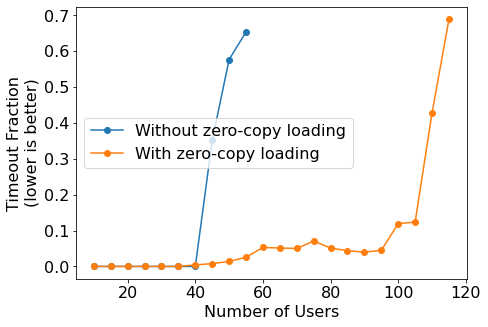

In [50]:
# Plot the two sets of results against each other.
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(7, 5))
plt.plot(baseline_stats['num_users'],
         baseline_stats['timeout_fraction'],
         '-o', label='Without zero-copy loading')
plt.plot(zerocopy_stats['num_users'],
         zerocopy_stats['timeout_fraction'],
         '-o', label="With zero-copy loading")
plt.xlabel('Number of Users')
plt.ylabel('Timeout Fraction\n(lower is better)')
plt.legend()

The baseline deployment can handle up to (TODO: Final number) users. Beyond that number, the CPU resources that are dedicated to the model with the highest traffic can no longer keep up with the increasingly large bursts of customer activity. Remember, the baseline deployment is stuck with a fixed allocation of CPU and memory because it hasn't been extensively tuned.

Our Ray-based deployment with zero-copy model loading, on the other hand, scales to (TODO: Final number) without any tuning. It achieves this scalability because it can instantly retask the underlying hardware resources to whatever models are currently experiencing high traffic.

